STEP 1: Setting up the environment...
Mounted at /content/drive
✅ Environment setup complete. Project assets will be saved to: /content/drive/MyDrive/AdvancedPotatoDiseaseModels

STEP 2: Acquiring and preparing the dataset...
Dataset URL: https://www.kaggle.com/datasets/abbasataiemontazer/potato-leaf
License(s): unknown
✅ Located base data directory at: potato_leaf_raw/Potato
✅ Dataset successfully organized.

STEP 3: Creating advanced data loading pipelines...
Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 3 classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
✅ Advanced data pipelines created.

STEP 4: Building and training models for comparison...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

--- Training EfficientNetB3 ---
Starting feature extraction...
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.3474 - loss: 1.2130
Epoch 1: val_loss improved from inf

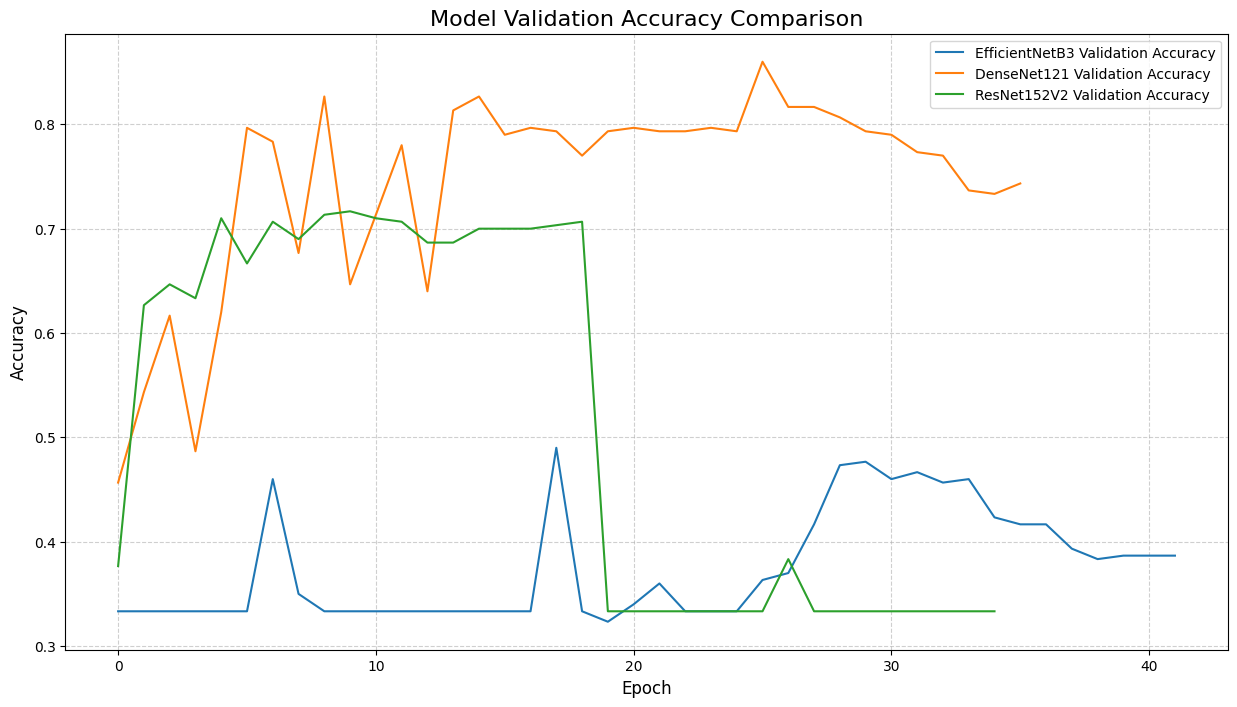


--- Evaluating EfficientNetB3 on Test Data ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 566ms/step - accuracy: 0.3866 - loss: 1.0968
Test Accuracy for EfficientNetB3: 37.33%

--- Evaluating DenseNet121 on Test Data ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 844ms/step - accuracy: 0.8821 - loss: 0.3561
Test Accuracy for DenseNet121: 83.00%

--- Evaluating ResNet152V2 on Test Data ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 503ms/step - accuracy: 0.7110 - loss: 0.6302
Test Accuracy for ResNet152V2: 68.67%

🏆 Best performing model is: DenseNet121 with 83.00% accuracy.

--- Detailed Report for DenseNet121 ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.80      0.94      0.87       100
 Potato___Late_blight       0.78      0.76      0.77       100
     Potato___healthy       0.92      0.79      0.85       100

             accuracy                           0.83       300
            macro avg       0.84 

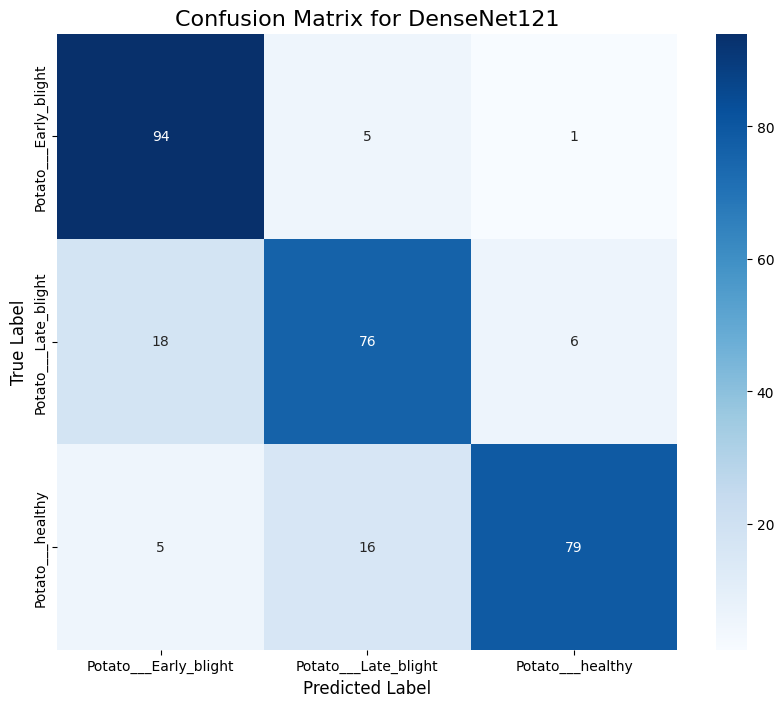

✅ Evaluation complete.

STEP 6: Launching Gradio Web Interface for the best model (DenseNet121)...


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8fd5a6dd29350f3779.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1310221248.py:287: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image.astype('uint8'), 'RGB').resize(IMG_SIZE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8fd5a6dd29350f3779.gradio.live


✅✅✅ PROJECT COMPLETE! ✅✅✅
The Gradio app for the best model (DenseNet121) is running above.
All trained models and assets are stored in: /content/drive/MyDrive/AdvancedPotatoDiseaseModels


In [ ]:
# -*- coding: utf-8 -*-
"""
advanced_potato_disease_classifier.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/your_new_notebook_location
"""

# ==============================================================================
# STEP 1: SETUP & ENVIRONMENT CONFIGURATION
# ==============================================================================
print("STEP 1: Setting up the environment...")

# Install necessary packages quietly
!pip install -q kaggle tensorflow

import os
import shutil
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gradio as gr
from google.colab import drive
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive to persist models and data
drive.mount('/content/drive')

# Configure Kaggle API
KAGGLE_JSON_PATH = "/content/drive/MyDrive/kaggle.json"
if not os.path.exists(KAGGLE_JSON_PATH):
    raise FileNotFoundError(f"Kaggle API token not found at {KAGGLE_JSON_PATH}. Please upload it to your Google Drive.")

!mkdir -p ~/.kaggle
!cp {KAGGLE_JSON_PATH} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Create a master directory in Google Drive for all project outputs
PROJECT_DIR = '/content/drive/MyDrive/AdvancedPotatoDiseaseModels'
os.makedirs(PROJECT_DIR, exist_ok=True)
print(f"✅ Environment setup complete. Project assets will be saved to: {PROJECT_DIR}")

# ==============================================================================
# STEP 2: DATA ACQUISITION & PREPARATION
# ==============================================================================
print("\nSTEP 2: Acquiring and preparing the dataset...")

# Download and unzip the dataset
!kaggle datasets download -d abbasataiemontazer/potato-leaf -q
!unzip -o -q potato-leaf.zip -d potato_leaf_raw

# Dynamic path finder
source_base_dir = None
for root, dirs, files in os.walk('potato_leaf_raw'):
    if 'Train' in dirs and 'Valid' in dirs and 'Test' in dirs:
        source_base_dir = root
        break
if source_base_dir is None:
    raise FileNotFoundError("Could not locate 'Train', 'Valid', 'Test' directories.")

print(f"✅ Located base data directory at: {source_base_dir}")

# Reorganize the dataset into a clean structure
if os.path.exists('dataset'):
    shutil.rmtree('dataset')

source_dirs = {
    'train': os.path.join(source_base_dir, 'Train'),
    'val': os.path.join(source_base_dir, 'Valid'),
    'test': os.path.join(source_base_dir, 'Test')
}

classes = os.listdir(source_dirs['train'])
for subset in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join('dataset', subset, cls), exist_ok=True)
        src_dir = os.path.join(source_dirs[subset], cls)
        dst_dir = os.path.join('dataset', subset, cls)
        if os.path.exists(src_dir):
            for filename in os.listdir(src_dir):
                shutil.copy(os.path.join(src_dir, filename), dst_dir)

shutil.rmtree('potato_leaf_raw')
print("✅ Dataset successfully organized.")

# ==============================================================================
# STEP 3: ADVANCED DATA LOADING & AUGMENTATION PIPELINE
# ==============================================================================
print("\nSTEP 3: Creating advanced data loading pipelines...")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train', label_mode='categorical', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/val', label_mode='categorical', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test', label_mode='categorical', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names_path = os.path.join(PROJECT_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Found {num_classes} classes: {class_names}")

# --- Advanced Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
], name="advanced_data_augmentation")

rescale = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)
print("✅ Advanced data pipelines created.")

# ==============================================================================
# STEP 4: MODEL BUILDING & TRAINING (COMPARATIVE ANALYSIS)
# ==============================================================================
print("\nSTEP 4: Building and training models for comparison...")

def build_model(model_name, num_classes):
    """Builds a model using a specified pre-trained base."""
    if model_name == 'EfficientNetB3':
        base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    elif model_name == 'DenseNet121':
        base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    elif model_name == 'ResNet152V2':
        base_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    else:
        raise ValueError("Unsupported model name")

    base_model.trainable = False  # Start with frozen base

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

def compile_and_train(model, base_model, model_name):
    """Compiles and trains the model in two phases: feature extraction and fine-tuning."""
    print(f"\n--- Training {model_name} ---")

    # Callbacks
    model_checkpoint_path = os.path.join(PROJECT_DIR, f'best_{model_name}.keras')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    # Phase 1: Feature Extraction
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Starting feature extraction...")
    history_feat_ext = model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Phase 2: Fine-Tuning
    model.load_weights(model_checkpoint_path)
    base_model.trainable = True
    # Fine-tune from this layer onwards
    fine_tune_at = int(len(base_model.layers) * 0.6) # Unfreeze top 40% of layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Starting fine-tuning...")
    history_fine_tune = model.fit(train_ds, epochs=50, initial_epoch=len(history_feat_ext.epoch), validation_data=val_ds, callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Save final model
    final_model_path = os.path.join(PROJECT_DIR, f'{model_name}_final.keras')
    model.save(final_model_path)
    print(f"✅ {model_name} training complete. Final model saved to: {final_model_path}")

    return history_feat_ext, history_fine_tune

# --- Train all models ---
model_histories = {}
models_to_train = ['EfficientNetB3', 'DenseNet121', 'ResNet152V2']

for model_name in models_to_train:
    model, base_model = build_model(model_name, num_classes)
    history_feat_ext, history_fine_tune = compile_and_train(model, base_model, model_name)
    model_histories[model_name] = {
        'feat_ext': history_feat_ext,
        'fine_tune': history_fine_tune
    }

# ==============================================================================
# STEP 5: MODEL EVALUATION & COMPARISON
# ==============================================================================
print("\nSTEP 5: Evaluating and comparing the models...")

# --- Plot comparative training history ---
plt.figure(figsize=(15, 8))
for model_name, histories in model_histories.items():
    val_acc = histories['feat_ext'].history['val_accuracy'] + histories['fine_tune'].history['val_accuracy']
    plt.plot(val_acc, label=f'{model_name} Validation Accuracy')

plt.title('Model Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Evaluate all models on the test set ---
test_results = {}
for model_name in models_to_train:
    print(f"\n--- Evaluating {model_name} on Test Data ---")
    model_path = os.path.join(PROJECT_DIR, f'best_{model_name}.keras')
    model = tf.keras.models.load_model(model_path)
    loss, accuracy = model.evaluate(test_ds)
    test_results[model_name] = accuracy
    print(f"Test Accuracy for {model_name}: {accuracy*100:.2f}%")

# --- Find and highlight the best model ---
best_model_name = max(test_results, key=test_results.get)
print(f"\n🏆 Best performing model is: {best_model_name} with {test_results[best_model_name]*100:.2f}% accuracy.")

# --- Detailed report for the best model ---
print(f"\n--- Detailed Report for {best_model_name} ---")
best_model_path = os.path.join(PROJECT_DIR, f'best_{best_model_name}.keras')
best_model = tf.keras.models.load_model(best_model_path)

y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
print("✅ Evaluation complete.")


# ==============================================================================
# STEP 6: INTERACTIVE WEB INTERFACE (GRADIO) FOR THE BEST MODEL
# ==============================================================================
print(f"\nSTEP 6: Launching Gradio Web Interface for the best model ({best_model_name})...")

def predict_potato_disease(image):
    """Predicts disease from an image using the best-performing model."""
    IMG_SIZE = (224, 224)
    rescale = tf.keras.layers.Rescaling(1./255)

    # Load the best model and class names
    best_model_path = os.path.join(PROJECT_DIR, f'best_{best_model_name}.keras')
    class_names_path = os.path.join(PROJECT_DIR, 'class_names.json')

    model = tf.keras.models.load_model(best_model_path)
    with open(class_names_path, 'r') as f:
        class_names = json.load(f)

    img = Image.fromarray(image.astype('uint8'), 'RGB').resize(IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = rescale(img_array)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    confidences = {class_names[i]: float(score[i]) for i in range(len(class_names))}
    return confidences

# Get example images
example_paths = []
if os.path.exists('dataset/test'):
    for cls in class_names:
        class_dir = os.path.join('dataset/test', cls)
        if os.path.exists(class_dir) and os.listdir(class_dir):
            example_paths.append(os.path.join(class_dir, os.listdir(class_dir)[0]))

# Create and launch the Gradio interface
iface = gr.Interface(
    fn=predict_potato_disease,
    inputs=gr.Image(type="numpy", label="Upload a potato leaf image"),
    outputs=gr.Label(num_top_classes=3, label="Predictions"),
    title=f"🥔 Advanced Potato Leaf Disease Detector ({best_model_name}) 🥔",
    description=f"This model uses the high-performing {best_model_name} architecture to classify potato leaf health. Upload an image to see the prediction.",
    examples=example_paths,
    cache_examples=False,
    allow_flagging="never"
)

iface.launch(share=True, debug=True)

print("\n\n==============================================================================")
print("✅✅✅ PROJECT COMPLETE! ✅✅✅")
print(f"The Gradio app for the best model ({best_model_name}) is running above.")
print(f"All trained models and assets are stored in: {PROJECT_DIR}")
print("==============================================================================")